In [2]:

import warnings
import logging

warnings.filterwarnings("ignore", ".*feasible.*")
logging.getLogger('matplotlib').setLevel(logging.WARNING)

DEBUG:matplotlib:CACHEDIR=C:\Users\matte\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\matte\.matplotlib\fontlist-v390.json


In [ ]:
from Declare4Py.D4PyEventLog import D4PyEventLog
from ga_objects.utils.tools import Tools
from ga_objects.utils.testSetup import Setup
import pandas as pd
import pm4py
from Declare4Py.ProcessMiningTasks.ConformanceChecking.MPDeclareAnalyzer import MPDeclareAnalyzer
from Declare4Py.ProcessMiningTasks.ConformanceChecking.MPDeclareResultsBrowser import MPDeclareResultsBrowser


xes_file = "ASP.xes"
save_path = "ASP.csv"
event_log = pm4py.read_xes(xes_file)
event_log.to_csv(save_path, index=False)

pop_size = 3000
trace_length = 50

# feasible_init_pop = Setup.initial_population("../declare_models/model1_initial_pop.csv",trace_length=50,trace_number=10)
feasible_init_pop = Setup.extract_traces("../declare_models/model3_initial_pop.csv")


encoder, d4py, event_log, dataframe, initial_encoded_pop, lower_bounds, upper_bounds = Setup.initialize_shared_components(
            path_to_declareModel="../declare_models/model2/model2.decl",
            trace_length=50,
            initial_population=feasible_init_pop
        )

timestamps = Tools.generate_random_timestamps(trace_length)

traces = Tools.load_traces_from_csv("results/03-24-20-44/encoded_traces/ID_1_run_1_ProblemSingle.csv")
data = {
            'case:concept:name': ['1'] * trace_length,
            'concept:name': feasible_init_pop[5],
            'timestamp': pd.to_datetime(timestamps),
}
dataframe = pd.DataFrame(data)

event_log = D4PyEventLog()
event_log.log = dataframe
event_log.timestamp_key = "timestamp"
event_log.activity_key = "concept:name"
event_log.to_eventlog()

basic_checker = MPDeclareAnalyzer(log=event_log, declare_model=d4py, consider_vacuity=True)
conf_check_res: MPDeclareResultsBrowser = basic_checker.run()

print(conf_check_res.get_metric(trace_id=0, metric="state"))
print(len(conf_check_res.get_metric(trace_id=0, metric="state")))
print("-------------------------------------------")
print(d4py.constraints[-4])

# Tools.calculate_overall_diversity(encoder,"results/03-26-21-45/encoded_traces/ID_3_run_1_ProblemSingle.csv",50)


# Tools.constraints_eval(dataframe,event_log,d4py,feasible_init_pop)


In [ ]:
from pymoo.operators.crossover.pntx import TwoPointCrossover
from ga_objects.operators.terminator import DiversityTermination
from ga_objects.operators.mutation import IntegerPolynomialMutation
from ga_objects.operators.sampling import MySampling
from pymoo.optimize import minimize
import warnings
import logging
from ga_objects.operators.terminator import ConstraintTermination
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination.default import DefaultMultiObjectiveTermination
from ga_objects.utils.testSetup import Setup

warnings.filterwarnings("ignore", ".*feasible.*")
logging.getLogger('matplotlib').setLevel(logging.WARNING)


pop_size = 300
trace_length = 50

# feasible_init_pop = Setup.extract_traces("../declare_models/model4/initial_pop_90.csv", trace_length)

random_pop = Setup.initial_random_population("../declare_models/model4/model4.decl",50,300)
# feasible_init_pop = Tools.extract_traces_from_xes("../declare_models/log_model2_refinedModel.xes", 50)
#
encoder, d4py, event_log, dataframe, initial_encoded_pop, lower_bounds, upper_bounds = Setup.initialize_shared_components(
            path_to_declareModel="../declare_models/model4/model4.decl",
            trace_length=trace_length,
            initial_population=random_pop
        )

problem = ProblemSingleTrace(
            trace_length=trace_length,
            encoder=encoder,
            d4py=d4py,
            initial_population=initial_encoded_pop,
            xl=lower_bounds,
            xu=upper_bounds,
            event_log=event_log,
            dataframe=dataframe,
)

# initialize the algorithm based on the arguments
algorithm = GA(
    problem=problem,
    pop_size=pop_size,
    sampling=MySampling(initial_population=initial_encoded_pop),
    crossover=TwoPointCrossover(prob=0.9),
    mutation=IntegerPolynomialMutation(prob=0.5, eta=1),
    eliminate_duplicates=True,
)



termination = DefaultMultiObjectiveTermination(
            xtol=1e-8, cvtol=1e-6, ftol=0.0025, period=30,
            n_max_gen=50000, n_max_evals=100000
        )

termination2 = DiversityTermination(0.95, 200)
termination3 = ConstraintTermination(1, "F", 0)


result = minimize(problem, algorithm, termination=termination3, verbose=True)




# encoded_traces = [traces]
# population = np.array(encoded_traces)

# diversity_score = np.mean(cdist(trace_path, trace_path, metric='hamming'))

# print(diversity_score)
# Tools.calculate_overall_diversity(encoder, trace_path, 90)


In [ ]:
from scipy.spatial.distance import pdist, squareform
from ga_objects.utils.tools import Tools
import numpy as np
from Declare4Py.ProcessModels.DeclareModel import DeclareModel
from ga_objects.utils import Encoder
from scipy.spatial.distance import cdist

pop_size = 4000
trace_length = 50

traces = Tools.extract_traces_from_xes("ASP.xes",50)

# feasible_init_pop = Tools.extract_traces_from_xes("../declare_models/log_model2_refinedModel.xes", 50)
#

path_to_declareModel="../declare_models/model4/model4.decl"

declare = DeclareModel().parse_from_file(path_to_declareModel)
activities = declare.activities
encoder = Encoder(activities)

file_path = save_path

encoded_traces = [encoder.encode(trace) for trace in traces]

population = np.array(encoded_traces)

print(population)

dist_matrix = cdist(population,population, metric='hamming')

print(dist_matrix.mean())

dist_matrix = squareform(pdist(population, metric="hamming"))
n = dist_matrix.shape[0]
mean_per_trace = (np.sum(dist_matrix, axis=1) - 0) / (n - 1)
print(len(dist_matrix))
print(mean_per_trace.mean())

dist_matrix = pdist(population, metric='hamming')
print(len(dist_matrix))
print(dist_matrix.mean())



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load your dataframe
df = pd.read_csv("results/04-16-01-59/result.csv", sep=',')

# Prepare figure with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)

# Make plots
for ax, tl in zip(axes, sorted(df['TraceLength'].unique())):
    sns.pointplot(
        data=df[df['TraceLength'] == tl],
        x='Population',
        y='DiversityScore',
        hue='Model',
        dodge=False,
        ci='sd',
        markers='o',
        ax=ax
    )
    ax.set_title(f'TraceLength {tl}')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax.legend().remove()

# Single legend to the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, title='Model',
    bbox_to_anchor=(0.92, 0.5),
    loc='center left', borderaxespad=0
)

fig.suptitle('DiversityScore vs Population Size for Each TraceLength', fontsize=18)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # leave space on the right
plt.savefig('combined_plot_population_vs_diversity.png', dpi=300, bbox_inches='tight')
plt.show()



C:\Users\matte\AppData\Local\Temp\ipykernel_6112\17713902.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
C:\Users\matte\AppData\Local\Temp\ipykernel_6112\17713902.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
C:\Users\matte\AppData\Local\Temp\ipykernel_6112\17713902.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
C:\Users\matte\AppData\Local\Temp\ipykernel_6112\17713902.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(


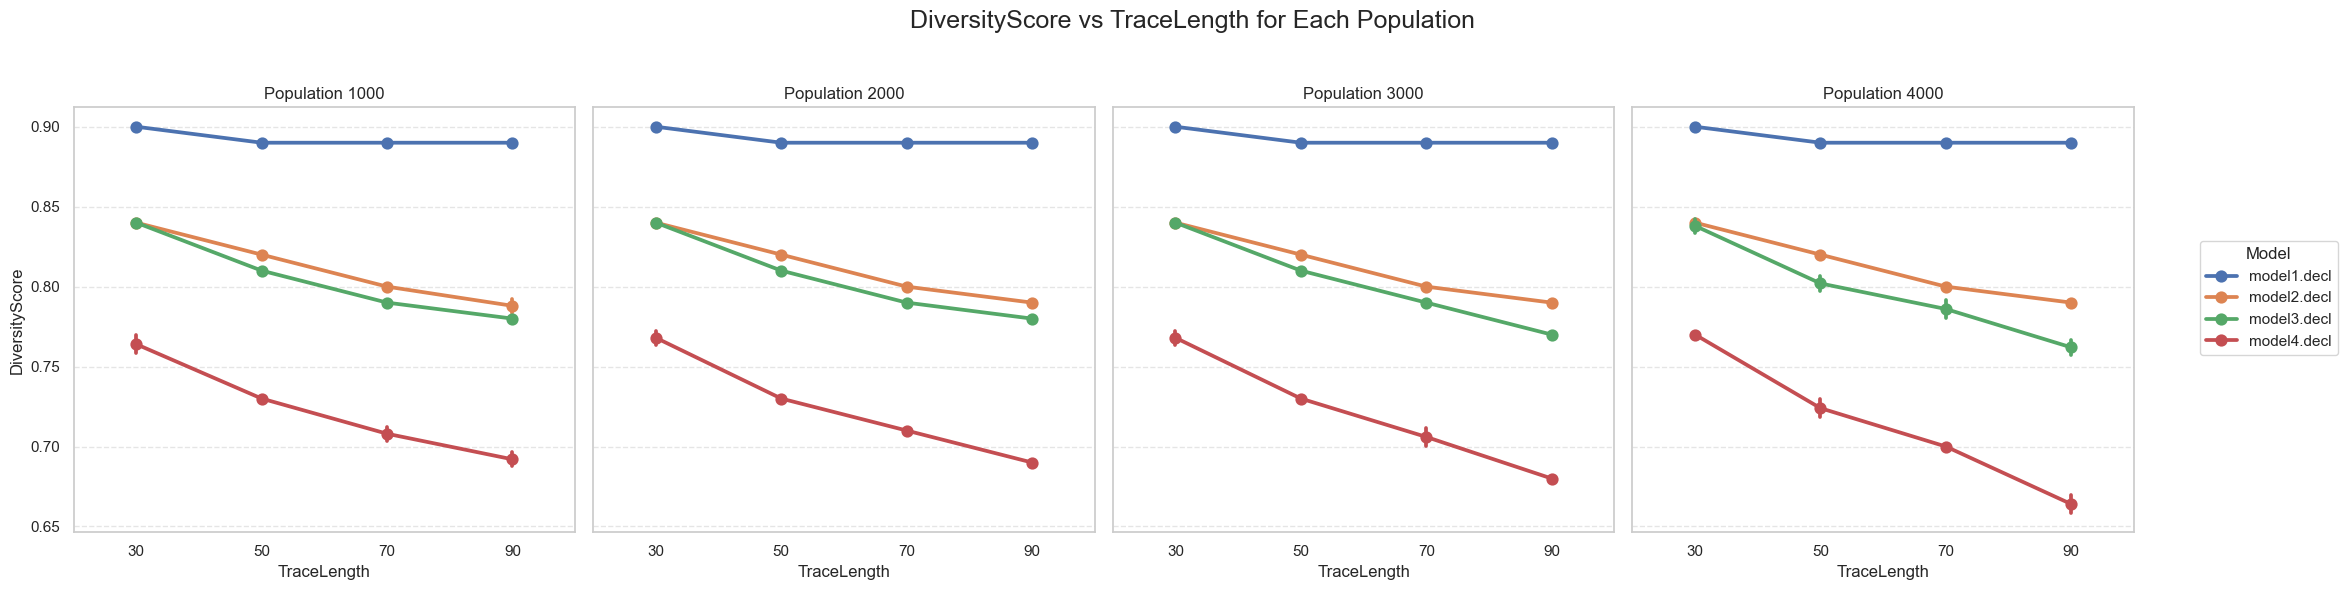

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(24, 6), sharey=True)



# Make plots
for ax, pop in zip(axes, sorted(df['Population'].unique())):
    sns.pointplot(
        data=df[df['Population'] == pop],
        x='TraceLength',
        y='DiversityScore',
        hue='Model',
        dodge=False,
        ci='sd',
        markers='o',
        ax=ax
    )
    ax.set_title(f'Population {pop}')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax.legend().remove()

# Single legend to the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, title='Model',
    bbox_to_anchor=(0.92, 0.5),
    loc='center left', borderaxespad=0
)

fig.suptitle('DiversityScore vs TraceLength for Each Population', fontsize=18)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # leave space on the right
plt.savefig('combined_plot_tracelength_vs_diversity.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\matte\AppData\Local\Temp\ipykernel_6112\2979618663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_df = df.groupby(['Population', 'TraceLength', 'Model']).apply(


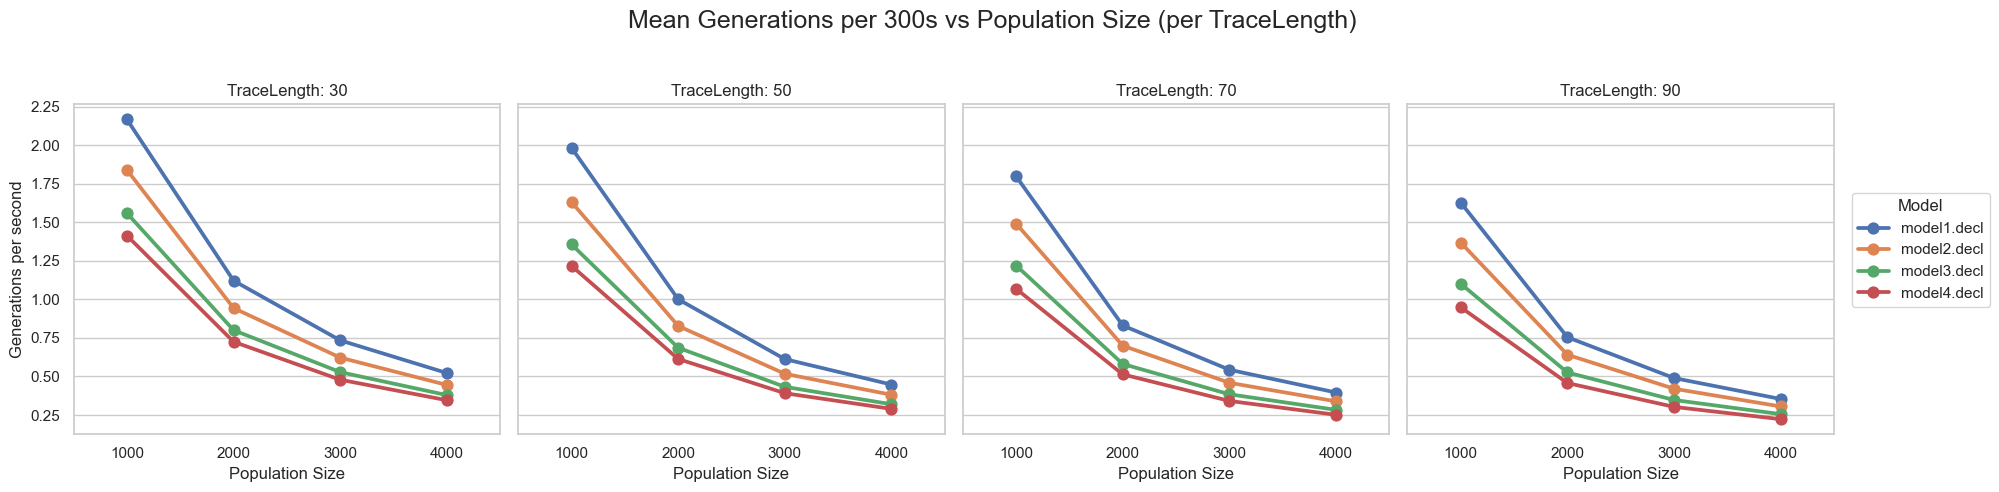

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("results/04-16-01-59/result.csv", sep=',')

# Compute mean Generations per 300s for each Population, TraceLength, Model
mean_df = df.groupby(['Population', 'TraceLength', 'Model']).apply(
    lambda g: (g['Generations'] / g['ExecutionTime']).mean()
).reset_index(name='Generations_per_s_mean')

# Unique TraceLengths
trace_lengths = mean_df['TraceLength'].unique()

fig, axes = plt.subplots(1, len(trace_lengths), figsize=(20, 5), sharey=True)

for ax, trace_length in zip(axes, trace_lengths):
    sns.pointplot(
        data=mean_df[mean_df['TraceLength'] == trace_length],
        x='Population',
        y='Generations_per_s_mean',
        hue='Model',
        dodge=False,
        ax=ax
    )
    ax.set_title(f'TraceLength: {trace_length}')
    ax.set_xlabel('Population Size')
    ax.set_ylabel('Generations per second')
    ax.legend().remove()

# One legend on the side
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, title='Model',
    bbox_to_anchor=(0.93, 0.5),
    loc='center left', borderaxespad=0
)

fig.suptitle('Mean Generations per 300s vs Population Size (per TraceLength)', fontsize=18)
plt.tight_layout(rect=[0, 0, 0.93, 0.95])
plt.savefig('mean_generations_per_300s_vs_population.png', dpi=300, bbox_inches='tight')
plt.show()


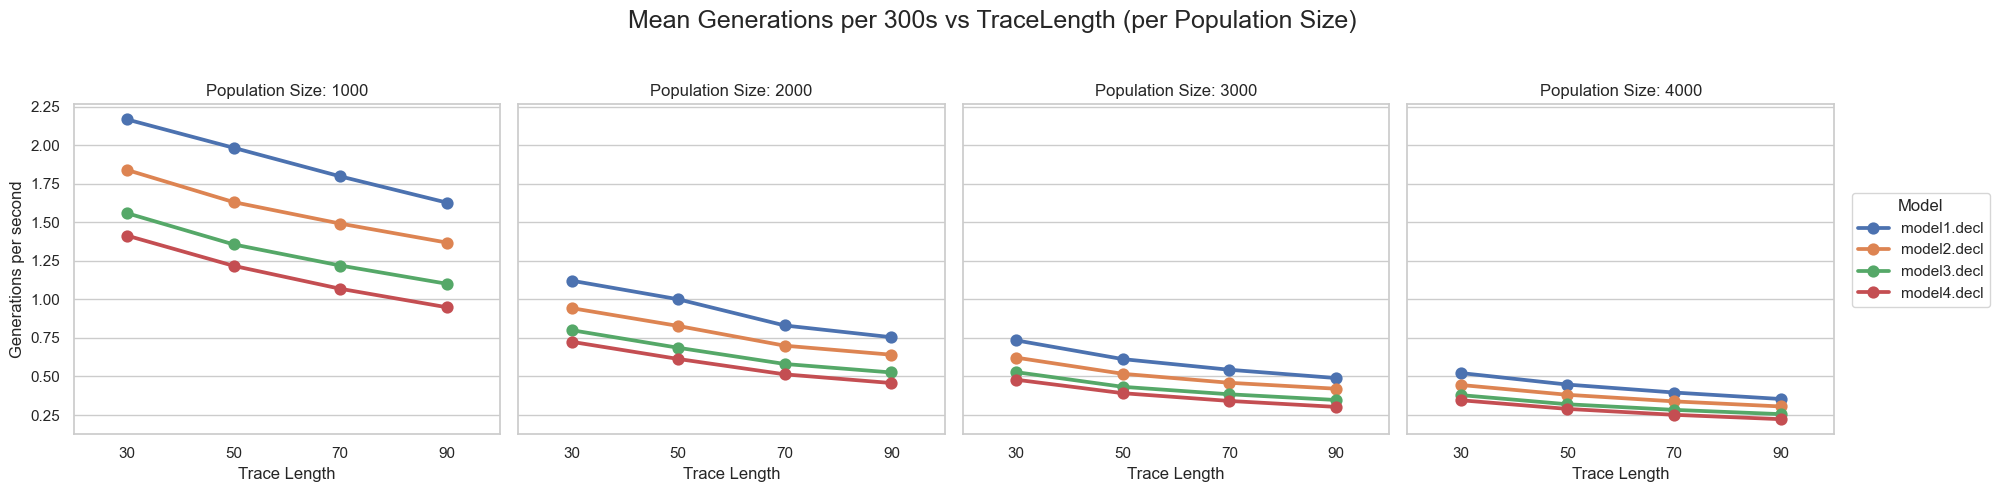

In [36]:
# Unique Populations
pop_sizes = mean_df['Population'].unique()

fig, axes = plt.subplots(1, len(pop_sizes), figsize=(20, 5), sharey=True)

for ax, pop_size in zip(axes, pop_sizes):
    sns.pointplot(
        data=mean_df[mean_df['Population'] == pop_size],
        x='TraceLength',
        y='Generations_per_s_mean',
        hue='Model',
        dodge=False,
        ax=ax
    )
    ax.set_title(f'Population Size: {pop_size}')
    ax.set_xlabel('Trace Length')
    ax.set_ylabel('Generations per second')
    ax.legend().remove()

# One legend on the side
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, title='Model',
    bbox_to_anchor=(0.93, 0.5),
    loc='center left', borderaxespad=0
)

fig.suptitle('Mean Generations per 300s vs TraceLength (per Population Size)', fontsize=18)
plt.tight_layout(rect=[0, 0, 0.93, 0.95])
plt.savefig('mean_generations_per_300s_vs_tracelength.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:

from Declare4Py.ProcessModels.DeclareModel import DeclareModel

from Declare4Py.ProcessMiningTasks.LogGenerator.ASP.ASPLogGenerator import AspGenerator
import time

model_name = 'model1'
model: DeclareModel = DeclareModel().parse_from_file(f"../declare_models/{model_name}/{model_name}.decl")

num_of_cases = 1000
(num_min_events, num_max_events) = (30,30)
verbose = False

asp_gen: AspGenerator = AspGenerator(model, num_of_cases, num_min_events, num_max_events, verbose=verbose)

start_time = time.time()

asp_gen.run()

end_time = time.time()

asp_gen.to_xes(f"ASP")
print(f"{end_time - start_time:.2f}s")

exporting log, completed traces :: 100%|██████████| 1000/1000 [00:00<00:00, 1845.95it/s]

21.95s


In [3]:
import os

str(os.cpu_count())

'12'